In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

In [ ]:
DIR_MAIN = '/content/drive/MyDrive/CCPS/DataSetSplit/SplitDataset/'

TEST_DIR = DIR_MAIN + 'test'
TRAIN_DIR = DIR_MAIN + 'train'
VAL_DIR = DIR_MAIN + 'val'

In [ ]:
IMG_SHAPE  = 224
batch_size = 32

In [ ]:
image_gen_train = ImageDataGenerator(rescale = 1./255)

train_data_gen = image_gen_train.flow_from_directory(
    batch_size = batch_size,
    directory = TRAIN_DIR,
    shuffle= True,
    target_size = (IMG_SHAPE,IMG_SHAPE),
    class_mode = 'categorical')


image_generator_validation = ImageDataGenerator(rescale=1./255)

val_data_gen = image_generator_validation.flow_from_directory(
    batch_size=batch_size,
    directory=VAL_DIR,
    target_size=(IMG_SHAPE, IMG_SHAPE),
    class_mode='categorical')

image_gen_test = ImageDataGenerator(rescale=1./255)

test_data_gen = image_gen_test.flow_from_directory(
    batch_size=batch_size,
    directory=TEST_DIR,
    target_size=(IMG_SHAPE, IMG_SHAPE),
    class_mode='categorical')

Found 2677 images belonging to 4 classes.
Found 764 images belonging to 4 classes.
Found 385 images belonging to 4 classes.


In [ ]:
dataset_labels = sorted(train_data_gen.class_indices.items(), key=lambda pair:pair[1])
dataset_labels = np.array([key.title() for key, value in dataset_labels])
print(dataset_labels)

['Benign' 'Early' 'Pre' 'Pro']


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub

In [ ]:
model = tf.keras.Sequential([
hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4",
output_shape=[1280],
trainable=False),
tf.keras.layers.Dropout(0.4),
tf.keras.layers.Dense(train_data_gen.num_classes, activation='softmax')
])

In [ ]:
model.build([None, IMG_SHAPE, IMG_SHAPE, 3])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 4)                 5124      
                                                                 
Total params: 2,263,108
Trainable params: 5,124
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
model.compile(
optimizer=tf.keras.optimizers.Adam(),
loss='categorical_crossentropy',
metrics=['acc'])

In [ ]:
steps_per_epoch = np.ceil(train_data_gen.samples/train_data_gen.batch_size)
val_steps_per_epoch = np.ceil(val_data_gen.samples/val_data_gen.batch_size)
hist = model.fit(
train_data_gen,
epochs=10,
verbose=1,
steps_per_epoch=steps_per_epoch,
validation_data=val_data_gen,
validation_steps=val_steps_per_epoch).history

Epoch 1/10
84/84 [==============================] - 873s 10s/step - loss: 0.6897 - acc: 0.7303 - val_loss: 0.3495 - val_acc: 0.8901
Epoch 2/10
84/84 [==============================] - 212s 3s/step - loss: 0.3082 - acc: 0.8984 - val_loss: 0.2917 - val_acc: 0.8992
Epoch 3/10
84/84 [==============================] - 170s 2s/step - loss: 0.2605 - acc: 0.9130 - val_loss: 0.2761 - val_acc: 0.9097
Epoch 4/10
84/84 [==============================] - 151s 2s/step - loss: 0.2339 - acc: 0.9182 - val_loss: 0.2472 - val_acc: 0.9175
Epoch 5/10
84/84 [==============================] - 147s 2s/step - loss: 0.2058 - acc: 0.9245 - val_loss: 0.2394 - val_acc: 0.9215
Epoch 6/10
84/84 [==============================] - 147s 2s/step - loss: 0.2042 - acc: 0.9320 - val_loss: 0.2551 - val_acc: 0.8992
Epoch 7/10
84/84 [==============================] - 148s 2s/step - loss: 0.1799 - acc: 0.9350 - val_loss: 0.2199 - val_acc: 0.9293
Epoch 8/10
84/84 [==============================] - 148s 2s/step - loss: 0.1703 - 

In [ ]:
# Save the model
ALL_SAVED_MODEL_PATH = '/content/drive/MyDrive/CCPS/NewModels/MobileNet.h5'
model.save(ALL_SAVED_MODEL_PATH)

In [ ]:
test_image_batch, test_label_batch = next(iter(test_data_gen))
true_label_ids = np.argmax(test_label_batch, axis=-1)
print("Test batch shape:", test_image_batch.shape)

Test batch shape: (32, 224, 224, 3)


In [ ]:
results = model.evaluate(test_image_batch, test_label_batch)

1/1 [==============================] - 1s 1s/step - loss: 0.2602 - acc: 0.9062


In [ ]:
results

[0.2601534426212311, 0.90625]

In [ ]:
import pandas as pd

In [ ]:
tf_model_predictions = model.predict(test_image_batch)
tf_pred_dataframe = pd.DataFrame(tf_model_predictions)
tf_pred_dataframe.columns = dataset_labels
print("Prediction results for the first elements")
tf_pred_dataframe.head()

1/1 [==============================] - 2s 2s/step
Prediction results for the first elements


,Benign,Early,Pre,Pro
0,0.078271,0.000021,0.000001,0.921706
1,0.003454,0.995224,0.000138,0.001185
2,0.097315,0.901465,0.001182,0.000037
3,0.000136,0.000199,0.999663,0.000002
4,0.935882,0.000246,0.000221,0.063650


In [ ]:
import matplotlib.pyplot as plt

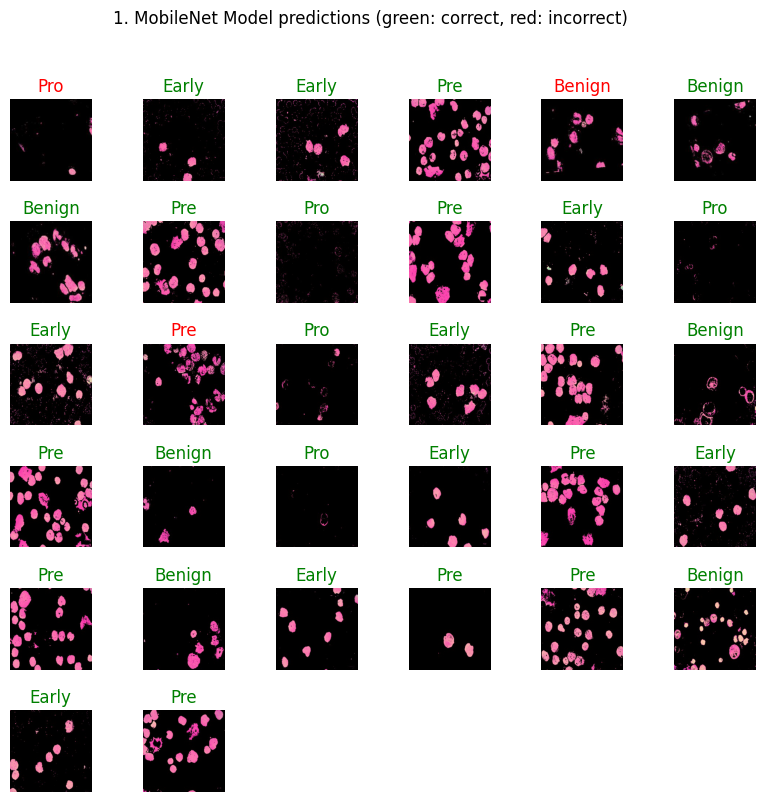

In [ ]:
predicted_ids_MobileNet = np.argmax(tf_model_predictions, axis=-1)
predicted_labels_MobileNet = dataset_labels[predicted_ids_MobileNet]
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(32):
  plt.subplot(6,6,n+1)
  plt.imshow(test_image_batch[n])
  color = "green" if predicted_ids_MobileNet[n] == true_label_ids[n] else "red"
  plt.title(predicted_labels_MobileNet[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("1. MobileNet Model predictions (green: correct, red: incorrect)")

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

In [ ]:
claRep = classification_report(true_label_ids, predicted_ids_MobileNet)
claRep

'              precision    recall  f1-score   support\n\n           0       0.86      0.75      0.80         8\n           1       1.00      1.00      1.00         9\n           2       0.91      1.00      0.95        10\n           3       0.80      0.80      0.80         5\n\n    accuracy                           0.91        32\n   macro avg       0.89      0.89      0.89        32\nweighted avg       0.90      0.91      0.90        32\n'

In [ ]:
cm = confusion_matrix(true_label_ids, predicted_ids_MobileNet)
accuracy = accuracy_score(true_label_ids, predicted_ids_MobileNet)
precision = precision_score(true_label_ids, predicted_ids_MobileNet, average='macro')
recall = recall_score(true_label_ids, predicted_ids_MobileNet, average='macro')
f1 = f1_score(true_label_ids, predicted_ids_MobileNet, average='macro')

# Print the metrics
print("Confusion Matrix:\n", cm)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Confusion Matrix:
 [[ 6  0  1  1]
 [ 0  9  0  0]
 [ 0  0 10  0]
 [ 1  0  0  4]]
Accuracy: 0.90625
Precision: 0.8915584415584417
Recall: 0.8875
F1 Score: 0.8880952380952382
